## Calibración de película y aplicación a un archivo tiff 
Dosepy versión 0.6.0

### Importar librerias

In [1]:
from Dosepy.image import load
from pathlib import Path

### Definir las dosis usadas para calibración

In [2]:
imparted_doses = [0, 0.5, 1, 1.5, 2, 3, 5, 8, 10]

### Lectura de archivo

Archivo tiff con películas irradiadas a los valores de dosis previos.

In [3]:
#file_path = Path("/home/luis/Downloads") / "POS48_1.tif"  # Office PC
file_path = Path("/home/luis/Descargas") / "POS48_1.tif" # Personal laptop
cal_image = load(file_path, for_calib = True)

### Generar curva de calibración
Se utilizará el canal rojo, una ROI rectangular de 16 mm x 8 mm y un ajuste a una función racional.

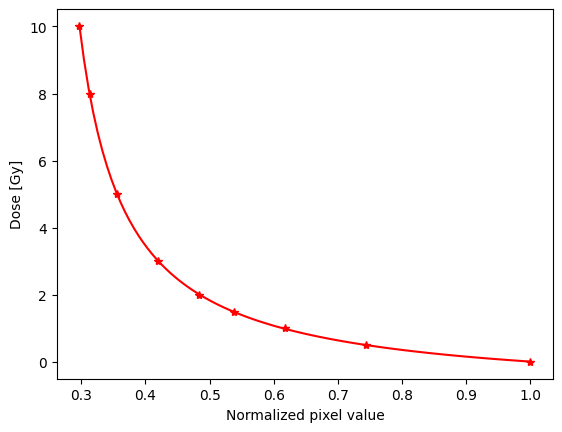

<Axes: xlabel='Normalized pixel value', ylabel='Dose [Gy]'>

In [4]:
cal = cal_image.get_calibration(doses = imparted_doses, channel = "R", roi = (16, 8), func = "RF")
cal.plot()

### Mostrar ROIs y valores medios de pixel.

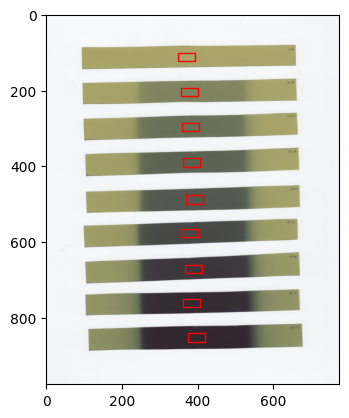

([27037, 24361, 22472, 20990, 19708, 17912, 15330, 13098, 12165],
 [131, 157, 138, 148, 134, 163, 143, 127, 288])

In [5]:
cal_image.get_stat(ch = 'B', roi = (16, 8), show = True)

## Aplicar curva a un nuevo archivo tiff


### Lectura de archivo

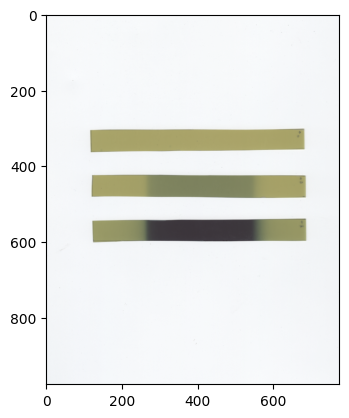

<Axes: >

In [6]:
#verif_path = Path("/home/luis/Downloads") / "VERIFICACION_1.tif"  # Office PC
verif_path = Path("/home/luis/Descargas") / "VERIFICACION_1.tif" # Personal laptop
verif = load(verif_path)

verif.plot()

### Aplicar curva 

In [7]:
dose_img = verif.to_dose(cal)

### Mostrar distribución

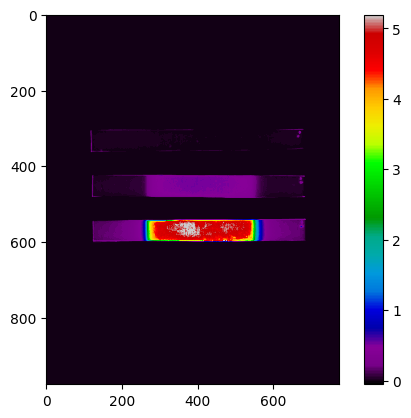

In [8]:

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(ncols=1)

# plot and save the
# color "mappable" object returned by ax.imshow
max_dose = np.percentile(dose_img.array, [99.9])[0]
#pos = ax.imshow(dose_img.array, cmap='turbo')
pos = ax.imshow(dose_img.array, cmap='nipy_spectral')
#pos = ax.imshow(dose_img.array)
pos.set_clim(-.05, max_dose)
#pos.set_clim(0, max_dose)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
fig.colorbar(pos, ax=ax)


## Guardar como archivo tiff (de utilidad para análisis con ImageJ)

### Numpy to bytes and cGy

In [9]:
import imageio.v3 as iio
#%matplotlib qt

data = np.int64(dose_img.array*100) # Gy to cGy

np_tif = data.astype(np.uint16)
png_encoded = iio.imwrite("<bytes>", np_tif, extension=".tif")


### Guardar como tiff

In [10]:
with open('test.tif', 'wb') as f: 
    f.write(png_encoded)

### Mostrar dosis promedio en ROI (...en desarrollo)

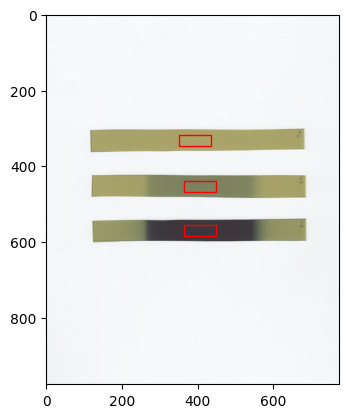

Dosis por ajuste racional: [0.00963348 0.51529858 5.01220582]


In [13]:
import numpy as np
from Dosepy.calibration import polynomial_g3, rational_func

mean_pixel, _ = verif.get_stat(ch = "R", roi = (30, 10), show = True)
mean_pixel = sorted(mean_pixel, reverse = True)

# Pixel normalization 
norm_pixel = np.array(mean_pixel)/mean_pixel[0]
dose_from_rational = rational_func(norm_pixel, *cal.popt)
print(f"Dosis por ajuste racional: {dose_from_rational}")


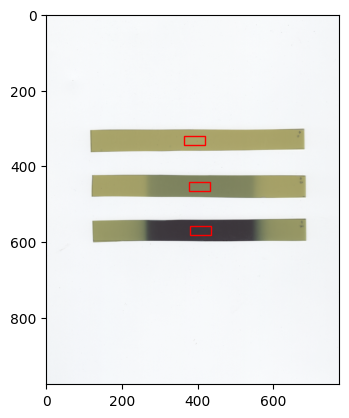

[0.00963348 0.51633034 5.00984937]


In [14]:
doses_in_central_rois = verif.doses_in_central_rois(cal, roi = (20, 8), show=True)
print(doses_in_central_rois)

In [15]:
type(doses_in_central_rois)

numpy.ndarray

In [16]:
dose_img.save_as_tif("tif_from_function")

In [17]:
%matplotlib qt

In [18]:
plt.imshow(dose_img.array)

## Calibración con vidrio y tapa

In [ ]:
#file_path_3 = Path("/home/luis/Downloads") / "POS48_3.tif"  # Office PC
file_path_3 = Path("/home/luis/Descargas") / "POS48_3.tif" # Personal laptop
cal_image_3 = load(file_path_3, for_calib = True)

In [ ]:
cal_3 = cal_image_3.get_calibration(doses = imparted_doses, channel = "B", roi = (16, 8), func = "P3")
cal_3.plot(color = 'blue')

In [ ]:
cal_image_3.get_stat(ch = 'B', roi = (16, 8), show = True)

In [ ]:
#verif_path_3 = Path("/home/luis/Downloads") / "VERIFICACION_3.tif"  # Office PC
verif_path_3 = Path("/home/luis/Descargas") / "VERIFICACION_3.tif" # Personal laptop
verif_3 = load(verif_path_3)

In [ ]:
mean_pixel_3, _ = verif_3.get_stat(ch = "B", roi = (30, 10), show = True)
mean_pixel_3 = sorted(mean_pixel_3, reverse = True)
#mean_pixel

optical_density_3 = -np.log10(np.array(mean_pixel_3)/mean_pixel_3[0])

dosis_from_fit_3 = polynomial_g3(optical_density_3, *cal_3.popt)
dosis_from_fit_3[dosis_from_fit_3 < 0] = 0 # Remove doses < 0

print(f"Dosis por ajuste: {dosis_from_fit_3}")


In [19]:
#import Dosepy.dose as dp
from Dosepy.image import load
import matplotlib.pyplot as plt
from importlib import resources

#   Cargamos los archivos "D_TPS.csv" y "D_FILM.csv"
#   (Los archivos de ejemplo .csv se encuentran dentro del paquete Dosepy, en la carpeta src/Dosepy/data)
#path_to_tps_csv_file = 
path_to_tps_csv_file = str(resources.files("Dosepy") / "data" / "D_TPS.csv")
np_tps = np.genfromtxt(path_to_tps_csv_file, delimiter = ",", comments = "#")
#>>> D_eval = dp.from_csv("D_TPS.csv", 1)
path_to_film_csv_file = str(resources.files("Dosepy") / "data" / "D_FILM.csv")
np_film = np.genfromtxt(path_to_film_csv_file, delimiter = ",", comments = "#")
#>>> D_ref = dp.from_csv("D_FILM.csv", 1)

D_tps = load(np_tps, dpi=25.4)
D_film = load(np_film, dpi=25.4)

#   Llamamos al método gamma2D, con criterio 3 %, 2 mm.
#>>> g, pass_rate = D_eval.gamma2D(D_ref, 3, 2)
g, pass_rate = D_tps.gamma2D(D_film, 3, 2)

#   Imprimimos el resultado
print(f'El índice de aprobación es: {pass_rate:.1f} %')
plt.imshow(g, vmax = 1.4)
plt.show()

#El índice de aprobación es: 98.9 %

El índice de aprobación es: 98.9 %
